# Memento 1K1K validation

In [9]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import itertools
from pybedtools import BedTool
import statsmodels.formula.api as smf
import statsmodels.api as sm
import sklearn.linear_model as lm

import os
import pickle as pkl
%matplotlib inline
import qvalue

In [10]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.8-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento

In [11]:
data_path  = '/data_volume/memento/lupus/'

### Read genotypes and covariates

In [54]:
asian_pos = pd.read_csv(data_path + 'mateqtl_input/asian_filtered_genos.tsv', sep='\t', index_col=0)
eur_pos = pd.read_csv(data_path + 'mateqtl_input/eur_filtered_genos.tsv', sep='\t', index_col=0)

In [55]:
asian_cov = pd.read_csv(data_path + 'mateqtl_input/asian_mateqtl_cov.txt', sep='\t', index_col=0).T
eur_cov = pd.read_csv(data_path + 'mateqtl_input/eur_mateqtl_cov.txt', sep='\t', index_col=0).T

### Run memento for the OneK eqtls

In [56]:
# Read the OneK result
onek_replication = pd.read_csv(data_path + 'filtered_onek_eqtls.csv')

In [57]:
cts = onek_replication.cg_cov.drop_duplicates().tolist()

In [58]:
# adata = sc.read(data_path + 'single_cell/{}.h5ad'.format(ct))
# adata = adata[adata.obs.ind_cov.isin(asian_pos.columns)].copy()

In [ ]:
# Run for asian population
for ct in cts:
    
    adata = sc.read(data_path + 'single_cell/asian_{}.h5ad'.format(ct))
    adata = adata[adata.obs.ind_cov.isin(asian_pos.columns)].copy()

    adata.obs['capture_rate'] = 0.1
    memento.setup_memento(adata, q_column='capture_rate', trim_percent=0.1, filter_mean_thresh=0.01)
    adata.obs['memento_size_factor'] = 1.0
    memento.create_groups(adata, label_columns=['ind_cov'])

#     cov_df = covariates[['age', 'status','Female'] + [x for x in covariates.columns if '_g' in x or '_e' in x]].loc[[x[3:] for x in adata.uns['memento']['groups']]]
    cov_df = asian_cov.loc[[x[3:] for x in adata.uns['memento']['groups']]]

    donor_df = asian_pos[[x[3:] for x in adata.uns['memento']['groups']]].T
    
    gene_snp_pairs = onek_replication.query('cg_cov == "{}"'.format(ct))
    memento.compute_1d_moments(adata, min_perc_group=.9, gene_list=gene_snp_pairs.gene.drop_duplicates().tolist())

    gene_to_snp = dict(gene_snp_pairs[gene_snp_pairs.gene.isin(adata.var.index)].groupby('gene').rsid.apply(list))
   
    memento.ht_1d_moments(
        adata, 
        covariate=cov_df,
        treatment=donor_df,
        treatment_for_gene=gene_to_snp,
        num_boot=5000, 
        verbose=1,
        num_cpus=93,
        resampling='bootstrap',
        approx=False,
        resample_rep=True)
    
#     adata.write(data_path + 'memento_1k/{}.h5ad'.format(ct))
    memento.get_1d_ht_result(adata).to_csv(data_path + 'memento_1k/asian_{}.csv'.format(ct), index=False)


In [ ]:
# Run for eur population
for ct in cts:
    
    adata = sc.read(data_path + 'single_cell/eur_{}.h5ad'.format(ct))
    adata = adata[adata.obs.ind_cov.isin(eur_pos.columns)].copy()

    adata.obs['capture_rate'] = 0.1
    memento.setup_memento(adata, q_column='capture_rate', trim_percent=0.1, filter_mean_thresh=0.01)
    adata.obs['memento_size_factor'] = 1.0
    memento.create_groups(adata, label_columns=['ind_cov'])

#     cov_df = covariates[['age', 'status','Female'] + [x for x in covariates.columns if '_g' in x or '_e' in x]].loc[[x[3:] for x in adata.uns['memento']['groups']]]
    cov_df = eur_cov.loc[[x[3:] for x in adata.uns['memento']['groups']]]

    donor_df = eur_pos[[x[3:] for x in adata.uns['memento']['groups']]].T
    
    gene_snp_pairs = onek_replication.query('cg_cov == "{}"'.format(ct))
    memento.compute_1d_moments(adata, min_perc_group=.9, gene_list=gene_snp_pairs.gene.drop_duplicates().tolist())

    gene_to_snp = dict(gene_snp_pairs[gene_snp_pairs.gene.isin(adata.var.index)].groupby('gene').rsid.apply(list))
   
    memento.ht_1d_moments(
        adata, 
        covariate=cov_df,
        treatment=donor_df,
        treatment_for_gene=gene_to_snp,
        num_boot=5000, 
        verbose=1,
        num_cpus=93,
        resampling='bootstrap',
        approx=False,
        resample_rep=True)
    
#     adata.write(data_path + 'memento_1k/{}.h5ad'.format(ct))
    memento.get_1d_ht_result(adata).to_csv(data_path + 'memento_1k/eur_{}.csv'.format(ct), index=False)


### Filter the pseudobulks by these genes

In [68]:
for ct in cts:
    
    memento_result = pd.read_csv(data_path + 'memento_1k/asian_{}.csv'.format(ct))
    pseudobulk = pd.read_csv(data_path + 'pseudobulk/asian_{}.csv'.format(ct), index_col=0, sep='\t')
    pseudobulk = pseudobulk[memento_result['gene'].drop_duplicates().tolist()]
    pseudobulk.T.to_csv(data_path + 'pseudobulk/asian_{}_filtered.csv'.format(ct), sep='\t')
    

In [70]:
for ct in cts:
    
    memento_result = pd.read_csv(data_path + 'memento_1k/eur_{}.csv'.format(ct))
    pseudobulk = pd.read_csv(data_path + 'pseudobulk/eur_{}.csv'.format(ct), index_col=0, sep='\t')
    pseudobulk = pseudobulk[memento_result['gene'].drop_duplicates().tolist()]
    pseudobulk.T.to_csv(data_path + 'pseudobulk/eur_{}_filtered.csv'.format(ct), sep='\t')
    

### Power calculation

In [24]:
# Power - Asian
for ct in cts:
    print(ct)
    meq = pd.read_csv(data_path + 'mateqtl_output/{}_filtered.out'.format(ct), sep='\t')
    mem = pd.read_csv(data_path + 'memento_1k/{}.csv'.format(ct))
    merged = mem.rename(columns={'tx':'SNP'}).merge(meq, on=['SNP', 'gene'])
    print(mem.shape[0], merged.shape[0])
    print('memento', mem.query('de_pval < 0.05').shape[0]/mem.shape[0], mem.query('de_pval < 0.05').shape[0])
    print('mat eqtl',merged[merged['p-value']<0.05].shape[0]/mem.shape[0], merged[merged['p-value']<0.05].shape[0])


B
907 907
memento 0.557883131201764 506
mat eqtl 0.3836824696802646 348
T8
1799 1799
memento 0.5308504724847137 955
mat eqtl 0.4563646470261256 821
T4
1826 1826
memento 0.5695509309967142 1040
mat eqtl 0.4923329682365827 899
NK
866 866
memento 0.4445727482678984 385
mat eqtl 0.3348729792147806 290
cM
340 340
memento 0.6911764705882353 235
mat eqtl 0.7088235294117647 241
ncM
230 230
memento 0.6565217391304348 151
mat eqtl 0.6260869565217392 144


In [15]:
# False positive rate
for ct in cts:
    print(ct)
    meq = pd.read_csv(data_path + 'mateqtl_output/{}_filtered_shuffled.out'.format(ct), sep='\t')
    mem = pd.read_csv(data_path + 'memento_1k/{}_shuffled.csv'.format(ct))
    merged = mem.rename(columns={'tx':'SNP'}).merge(meq, on=['SNP', 'gene'])
    print('memento', mem.query('de_pval < 0.05').shape[0]/mem.shape[0])
    print('mat eqtl',merged[merged['p-value']<0.05].shape[0]/merged.shape[0])

B
memento 0.06399235912129896
mat eqtl 0.04180064308681672
T8
memento 0.0583596214511041
mat eqtl 0.050359712230215826
T4
memento 0.05263157894736842
mat eqtl 0.049145299145299144
NK
memento 0.0420017873100983
mat eqtl 0.059782608695652176
ncM
memento 0.07580174927113703
mat eqtl 0.046511627906976744
cM
memento 0.03550295857988166
mat eqtl 0.05673758865248227


In [138]:
0.070865/0.055182

1.284204994382226

In [170]:
covariates.head(5)

,age,Female,batch_cov,status,PC1_e,PC2_e,PC3_e,PC4_e,PC5_e,PC6_e,...,PC8_e,PC9_e,PC10_e,PC1_g,PC2_g,PC3_g,PC4_g,PC5_g,PC6_g,PC7_g
HC-519,21.0,0.0,13.0,1.0,8.582570,-22.828452,17.259928,-5.124023,0.542451,-0.780524,...,-0.425329,7.169390,5.309465,0.0343,-0.0456,0.0413,-0.0635,0.1212,-0.0581,0.0352
1240_1240,23.0,0.0,3.0,0.0,-8.648941,13.411016,5.855519,7.568020,-8.009542,-0.186709,...,2.021136,0.919464,0.047876,-0.0049,0.2181,-0.0730,-0.0005,-0.1076,0.0217,-0.0766
HC-022,74.0,0.0,14.0,1.0,2.728118,-13.795299,1.074720,7.365269,10.467058,-6.088037,...,1.454213,-5.778323,-6.239999,0.0508,0.0020,0.0465,0.1017,-0.1011,0.1246,-0.0559
1771_1771,49.0,0.0,7.0,0.0,-7.359370,10.981154,-0.085993,-23.435739,-0.616778,4.374860,...,-2.862667,9.843410,2.890764,-0.4201,-0.0699,0.0289,0.0594,0.0049,0.0146,0.0126
1472_1472,45.0,0.0,9.0,0.0,-10.204806,12.005469,-18.111741,-6.703906,-3.399169,3.591684,...,-3.815207,5.573024,-1.693832,-0.2214,0.0946,-0.0603,0.0916,-0.0429,-0.0987,0.0742


In [26]:
adata = sc.read(data_path + 'single_cell/{}.h5ad'.format(ct))
expr_df = pd.DataFrame()
expr_df['expr'] = adata[:, 'HLA-DQA1'].X.todense().A1
expr_df['ind_cov'] = adata.obs['ind_cov'].values
expr_df = expr_df.merge(pos.T.reset_index().rename(columns={'index':'ind_cov'})[['ind_cov', '6:32606756']], on='ind_cov')
expr_df = expr_df.merge(covariates.reset_index().rename(columns={'index':'ind_cov'}), on='ind_cov')
ind_list = expr_df['ind_cov'].drop_duplicates().tolist()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [27]:
expr_dict = {ind:expr_df.query('ind_cov == "{}"'.format(ind)).expr.values for ind in ind_list}
geno_dict= {ind:expr_df.query('ind_cov == "{}"'.format(ind))['6:32606756'].mean() for ind in ind_list}

In [28]:
num_rep = len(ind_list)

In [29]:
b_coefs = np.zeros(5000)
for boot_itr in range(5000):
    
    means = np.zeros(num_rep)
    genos = np.zeros(num_rep)
    boot_inds = np.random.choice(ind_list, num_rep)
    for i, ind in enumerate(boot_inds):
        means[i] = np.log(np.random.choice(expr_dict[ind], size=expr_dict[ind].shape[0]).mean()+1)
        genos[i] = geno_dict[ind]
    coef = lm.LinearRegression().fit(np.hstack([genos.reshape(-1,1), covariates.loc[boot_inds, :]]), means.reshape(-1,1)).coef_[0][0]
    b_coefs[boot_itr] = coef
        
        

In [30]:
stats.norm.sf(0, loc=b_coefs.mean(), scale=b_coefs.std())

0.009343063956403932

In [31]:
stats.norm.sf(0, loc=b_coefs.mean(), scale=b_coefs.std())

0.009343063956403932

<AxesSubplot:ylabel='Density'>

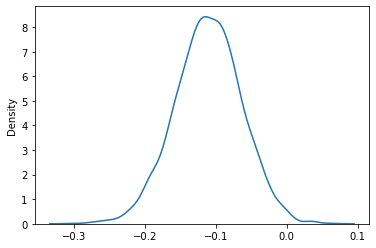

In [32]:
sns.kdeplot(b_coefs)

(array([1.1769e+05, 3.5380e+03, 1.0990e+03, 4.4400e+02, 1.8700e+02,
        1.2400e+02, 3.5000e+01, 1.9000e+01, 1.3000e+01, 4.0000e+00]),
 array([ 0. ,  2.2,  4.4,  6.6,  8.8, 11. , 13.2, 15.4, 17.6, 19.8, 22. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

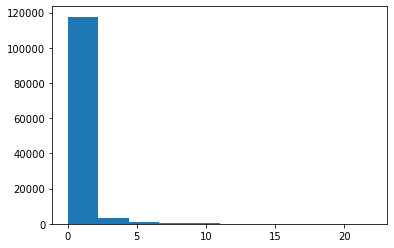

In [34]:
plt.hist(expr_df['expr'])

In [35]:
merged[(merged['de_pval'] > 0.05) & (merged['p-value'] < 0.05)]

,gene,SNP,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,beta,t-stat,p-value,FDR
26,NAGK,2:71297982,-0.021954,0.014456,0.1312,-0.058271,0.090391,0.5094,-0.040998,-4.004192,0.000147,0.494679
28,DBI,2:120122538,-0.035541,0.018912,0.0598,-0.071333,0.101440,0.4754,-0.047208,-2.707891,0.008405,0.999747
50,LY86,6:6580752,0.006995,0.011800,0.5412,0.011583,0.061773,0.8434,0.031648,2.098055,0.039314,0.999747
51,RNF144B,6:18399394,-0.028675,0.015293,0.0556,-0.163962,0.120814,0.1756,-0.029998,-3.587793,0.000596,0.774752
61,HLA-B,6:31236467,0.072618,0.043975,0.0954,0.122051,0.077401,0.1136,0.105643,2.396146,0.019096,0.999747
68,HLA-DQA1,6:32606756,-0.036989,0.029423,0.2056,-0.325402,0.157475,0.0398,-0.094538,-2.085104,0.040509,0.999747
75,DEF6,6:35282463,0.001923,0.002905,0.5052,0.057247,0.100141,0.5718,0.010933,3.392208,0.001116,0.881418
76,RPL10A,6:35436925,-0.042162,0.033861,0.2150,0.066044,0.089817,0.4628,-0.112138,-3.431682,0.000985,0.869185
81,MRPL14,6:44105978,-0.007528,0.007106,0.2892,0.004171,0.123110,0.9716,-0.025175,-4.674135,0.000013,0.104600
139,AP003774.6,11:64158950,-0.003973,0.002667,0.1410,-0.156414,0.124523,0.2078,-0.009340,-3.283494,0.001567,0.916465


In [77]:
ct = 'cM'

In [81]:
meq = pd.read_csv(data_path + 'mateqtl_output/{}_filtered_old.out'.format(ct), sep='\t')
mem = pd.read_csv(data_path + 'memento_1k/{}.csv'.format(ct))

In [82]:
mem.shape

(338, 8)

In [90]:
merged = mem.rename(columns={'tx':'SNP'}).merge(meq[meq['p-value']<0.05], on=['SNP', 'gene'])

In [84]:
merged.shape

(235, 12)

In [87]:
mem.query('de_pval < 0.05').shape[0]/mem.shape[0]

0.5414201183431953

In [93]:
merged.shape[0]/mem.shape[0]

0.6686390532544378

In [105]:
pb1 = pd.read_csv(data_path + 'pseudobulk/{}_filtered.csv'.format(ct), sep='\t', index_col=0).T

In [110]:
pb2 = pd.read_csv(data_path + 'mateqtl_input/cm_cg.expr', sep='\t', index_col=0).T

In [113]:
common_col = list(set(pb1.columns) & set(pb2.columns))

In [114]:
pb1 = pb1[common_col]
pb2 = pb2[common_col]

In [115]:
pb1.head(2)

,MANBA,CHMP4B,GCNT2,TULP4,NUBP2,ELP5,PRMT2,RP11-290F20.3,SUSD3,ZBTB22,...,RPP21,TMEM176A,CST3,ABRACL,CSNK2B,HLA-DRB1,EREG,KDELR2,MRPL14,CRISPLD2
HC-519,0.038563,0.118353,0.001708,0.007663,0.029476,0.009358,0.062935,0.103050,0.009358,0.006814,...,0.021142,0.015268,1.163957,0.123654,0.133425,0.486955,0.159994,0.078068,0.066140,0.038563
1791_1791,0.097786,0.271953,0.016069,0.012174,0.081895,0.024587,0.151495,0.240768,0.028050,0.011393,...,0.036847,0.081895,2.125437,0.254646,0.277356,1.093460,0.138163,0.179619,0.132988,0.108477


In [116]:
pb2.head(2)

Unnamed: 0,MANBA,CHMP4B,GCNT2,TULP4,NUBP2,ELP5,PRMT2,RP11-290F20.3,SUSD3,ZBTB22,...,RPP21,TMEM176A,CST3,ABRACL,CSNK2B,HLA-DRB1,EREG,KDELR2,MRPL14,CRISPLD2
HC-519,5.414605,7.057960,1.672425,3.242791,5.035064,3.493156,6.120243,6.849347,3.493156,3.099173,...,4.573959,4.132487,11.175467,7.124389,7.240184,9.365807,7.519456,6.436379,6.192798,5.414605
1240_1240,5.548255,6.937241,3.156325,3.240748,5.036711,3.536299,6.104814,6.385398,3.890027,2.699946,...,3.664090,6.116033,11.822846,7.426109,7.569707,10.591394,7.821756,6.149176,6.357310,4.630257
